# Customer Segmentation with K-Means Clustering

**Goal:** Segment mall customers into distinct groups based on their annual income and spending score, so as to tailor marketing strategies for each cluster.  
**Dataset:** `Mall_Customers.csv`  
**Tools:** Pandas, NumPy, scikit-learn, Matplotlib, Seaborn  

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

sns.set(style="whitegrid")
%matplotlib inline

## 2. UPLOAD & LOAD DATA  
We upload `Mall_Customers.csv` and take an initial look at its structure and basic statistics.


In [4]:
df = pd.read_csv("Mall_Customers.csv")
print("Shape:", df.shape)
display(df.head())
display(df.describe())

Shape: (200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [6]:
print(df.columns.tolist())


['CustomerID', 'Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']


## 3. EXPLORATORY DATA ANALYSIS (EDA)  
Visualize distributions of key features and relationships between them.


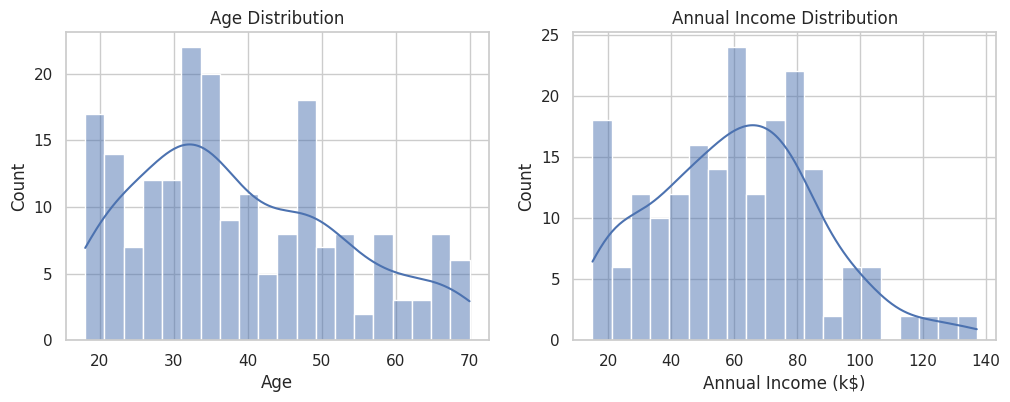

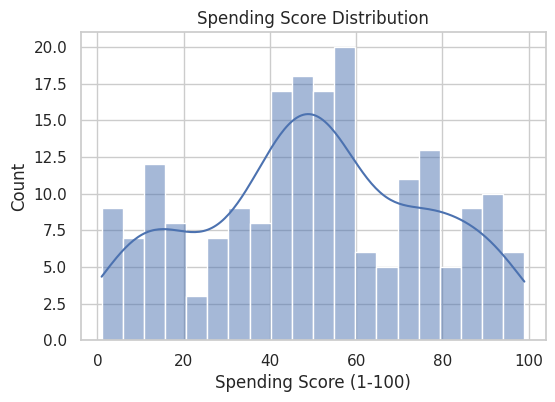

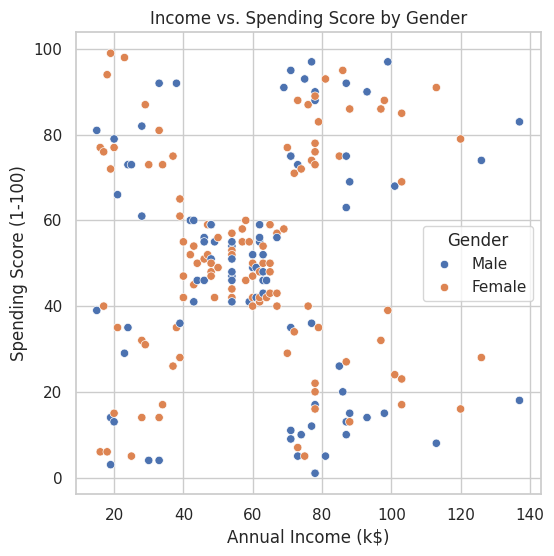

In [8]:
# Histograms
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df['Age'], bins=20, kde=True, ax=axes[0]).set_title("Age Distribution")
sns.histplot(df['Annual Income (k$)'], bins=20, kde=True, ax=axes[1]).set_title("Annual Income Distribution")
plt.show()

# Spending Score
plt.figure(figsize=(6,4))
sns.histplot(df['Spending Score (1-100)'], bins=20, kde=True).set_title("Spending Score Distribution")
plt.show()

# Scatter: Income vs. Spending Score
plt.figure(figsize=(6,6))
sns.scatterplot(
    x='Annual Income (k$)',
    y='Spending Score (1-100)',
    hue='Gender',
    data=df
)
plt.title("Income vs. Spending Score by Gender")
plt.show()


## 4. DATA PREPROCESSING  
We select the features for clustering and standardize them to have mean 0 and unit variance.


In [10]:
# Select features
X = df[['Annual Income (k$)', 'Spending Score (1-100)']].values
# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Mean after scaling (should ≈0):", X_scaled.mean(axis=0))
print("Std after scaling (should =1):", X_scaled.std(axis=0))


Mean after scaling (should ≈0): [-2.13162821e-16 -1.46549439e-16]
Std after scaling (should =1): [1. 1.]


## 5. FINDING OPTIMAL NUMBER OF CLUSTERS  
We use the **Elbow Method** (WCSS) and **Silhouette Scores** to choose k between 2 and 10.


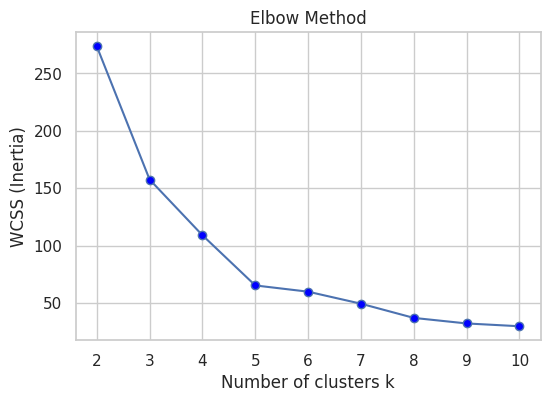

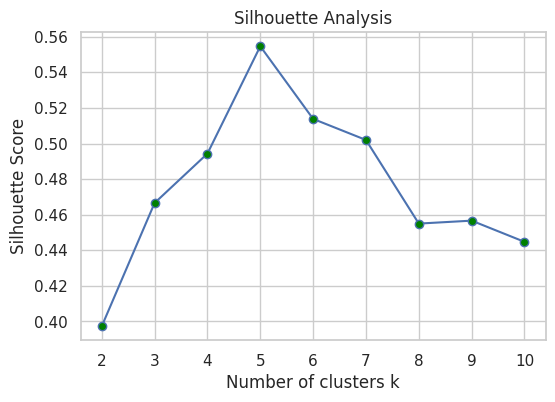

In [11]:
wcss = []
sil_scores = []
K = range(2, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    wcss.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Plot WCSS
plt.figure(figsize=(6,4))
plt.plot(K, wcss, 'o-', markerfacecolor='blue')
plt.xlabel('Number of clusters k')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method')
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(6,4))
plt.plot(K, sil_scores, 'o-', markerfacecolor='green')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()


## 6. FIT K-MEANS & ASSIGN CLUSTERS  
From the plots above, choose the best k (e.g., k=5) and fit the final model.


In [12]:
best_k = 5
kmeans = KMeans(n_clusters=best_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)


## 7. CLUSTER VISUALIZATION  
Visualize the clusters on the feature space (income vs. spending score).


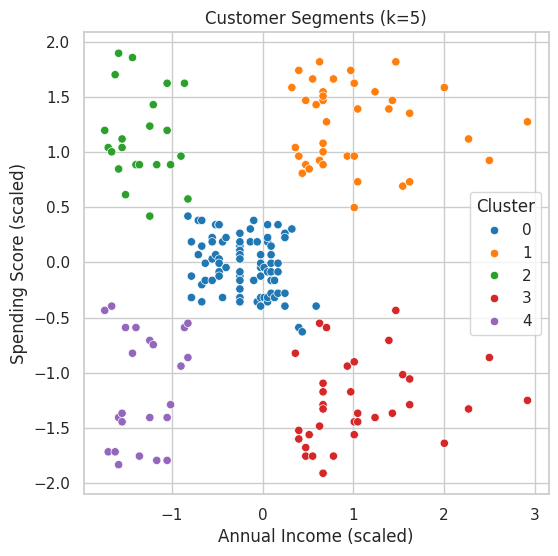

In [13]:
plt.figure(figsize=(6,6))
sns.scatterplot(
    x=X_scaled[:,0], y=X_scaled[:,1],
    hue=df['Cluster'], palette='tab10',
    legend='full'
)
plt.xlabel('Annual Income (scaled)')
plt.ylabel('Spending Score (scaled)')
plt.title(f'Customer Segments (k={best_k})')
plt.show()


## 8. CLUSTER PROFILING  
Compute the mean Age, Annual Income, and Spending Score per cluster to understand each segment.


In [15]:
profile = df.groupby('Cluster')[['Age','Annual Income (k$)','Spending Score (1-100)']].mean().round(1)
display(profile)


,Age,Annual Income (k$),Spending Score (1-100)
Cluster,,,
0,42.7,55.3,49.5
1,32.7,86.5,82.1
2,25.3,25.7,79.4
3,41.1,88.2,17.1
4,45.2,26.3,20.9


## CLUSTER PROFILING INTERPRETATION

Based on the mean values for each cluster:

| Cluster | Age (years) | Annual Income (k$) | Spending Score (1–100) | Segment Description                  |
|:-------:|:-----------:|:-------------------:|:----------------------:|---------------------------------------|
| **0**   | 42.7        | 55.3                | 49.5                   | **“Balanced Mainstream”**<br>Middle-aged, moderate income & spending—your core customer base. |
| **1**   | 32.7        | 86.5                | 82.1                   | **“High-Value Spenders”**<br>Younger, high income & high spending—premium, loyal buyers.    |
| **2**   | 25.3        | 25.7                | 79.4                   | **“Young Impulse Shoppers”**<br>Very young, lower income but high spending—trend-driven, impulse purchasers. |
| **3**   | 41.1        | 88.2                | 17.1                   | **“Reserved High-Earners”**<br>Middle-aged, high income but low spending—selective, price-conscious. |
| **4**   | 45.2        | 26.3                | 20.9                   | **“Budget-Conscious”**<br>Older, lower income & low spending—very price-sensitive shoppers. |

### Marketing & Business Implications

- **Cluster 0 (Balanced Mainstream):**  
  - **Strategy:** General promotions, loyalty rewards, mid-tier product bundles.  
  - **Goal:** Retain as stable revenue contributors.

- **Cluster 1 (High-Value Spenders):**  
  - **Strategy:** Exclusive VIP programs, early access to new products, premium upsells.  
  - **Goal:** Increase lifetime value & brand advocacy.

- **Cluster 2 (Young Impulse Shoppers):**  
  - **Strategy:** Flash sales, social-media campaigns, buy-now-pay-later options, limited-edition drops.  
  - **Goal:** Capitalize on trendiness and impulsiveness.

- **Cluster 3 (Reserved High-Earners):**  
  - **Strategy:** Personalized recommendations, bundling discounts, free-shipping thresholds.  
  - **Goal:** Nudge occasional big spenders toward more frequent purchases.

- **Cluster 4 (Budget-Conscious):**  
  - **Strategy:** Discount coupons, value bundles, loyalty points on low-cost items.  
  - **Goal:** Encourage trial and gradual upsell as income allows.




## Final Takeaways & Next Steps

1. **Segmentation Success**  
   – Identified five distinct customer groups with unique profiles (e.g., High-Value Spenders, Budget-Conscious).  
   – Enabled data-driven marketing strategies tailored to each segment’s income and spending behavior.

2. **Business Recommendations**  
   – **High-Value Spenders:** VIP programs & premium bundles  
   – **Young Impulse Shoppers:** Flash sales & social-media activations  
   – **Reserved High-Earners:** Personalized offers & free-shipping incentives  
   – **Budget-Conscious:** Discount coupons & value packs  
   – **Balanced Mainstream:** Loyalty rewards & core promotions

3. **Model Validation**  
   – Used the Elbow Method and Silhouette Score to choose **k = 5** clusters.  
   – Standardized features to ensure fair distance measurements.

4. **Limitations**  
   – Only two features (income & spending) were used—additional variables (Age, Gender, online behavior) could refine segments.  
   – K-Means assumes spherical clusters of similar size; alternative algorithms may uncover different groupings.

5. **Next Steps**  
   - **Enrich Data:** Incorporate demographics, channel preferences, transaction history.  
   - **Advanced Clustering:** Experiment with DBSCAN or hierarchical clustering.  
   - **Dimensionality Reduction:** Use PCA or t-SNE for multi-feature visualization.  
   - **Action Tracking:** After targeted campaigns, measure uplift per segment to validate and iterate.
